In [35]:
import h5py
import numpy as np
import pandas as pd
import phenograph
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn import manifold
%matplotlib inline
from sklearn.manifold import TSNE
import scanpy.api as sc
from collections import Counter
from sklearn.metrics import mutual_info_score
from sklearn.metrics import jaccard_similarity_score
from numba import jit
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [54]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [14]:
@jit
def subsample(matrix, proportion=0.8):
    # proportion percentages are going to be kept the same
    n_samples_without_replacement = int(matrix.shape[0]*proportion)
    n_samples_with_replacement = matrix.shape[0]-n_samples_without_replacement
    subsampled = matrix.sample(n=n_samples_without_replacement, replace=False)
    subsampled2 = subsampled.sample(n=n_samples_with_replacement, replace=False)
    subsampled_final = pd.concat((subsampled, subsampled2), axis=0)
    np.random.shuffle(subsampled_final)
    return subsampled_final

def preprocess_zheng17(matrix):
    mask1 = (matrix.sum(axis=0) > 3)
    filtered_matrix = matrix [:,mask1]
    adata = sc.AnnData(filtered_matrix)
    sc.pp.normalize_per_cell(adata)
    filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=1000, log=False)
    mask2 = filter_result.gene_subset
    adata = adata[:, mask2]
    sc.pp.normalize_per_cell(adata)
    matrix = adata.X
    return matrix

def run_phenograph(matrix):
    current = time.time()
    communities, graph, Q = phenograph.cluster(matrix, n_jobs=8, k=100, primary_metric='euclidean')
    end = time.time()
    diff = end - current
    print(diff)
    return communities

@jit
def compute_jaccard(list1, list2):
    intersection = len(set(list1) & set(list2))
    union = len(set(list1) | set(list2))
    return intersection / union

In [16]:
input_file = '/cluster/home/mtuncel/sc-pipe/intermediate_files/coding_region_only_melanomaS2.h5'

In [17]:
h5f = h5py.File(input_file, 'r')

In [19]:
h5f = h5py.File(input_file, 'r')
matrix = h5f['matrix'][:]
barcodes = h5f['cell_attrs']['cell_names'].value
#cell_groups = h5f['cell_attrs']['cell_groups'].value

matrix = np.log1p(matrix)

In [22]:
h5f.close()

In [64]:
%%capture
preprocessed = preprocess_zheng17(matrix)
communities = run_phenograph(preprocessed)

In [25]:
original_df = pd.DataFrame(matrix)

In [26]:
original_df['labels'] = communities
original_df['original_index'] = original_df.index

## Assessment of cluster robustness

The evaluation procedure is described in the following publication: “Cluster-wise assessment of cluster stability,” Research Report 271, Dept. of Statistical Science, University College London, December 2006)
<br>

Given a clustering on a data set generated by a clustering method, the following principle is applied:
* Interpret the Jaccard coefficient (Jaccard, 1901) as a measure of similarity between two subsets of a set based on set membership.
* Resample new data sets from the original one (using various strategies) and apply the clustering method to them. 
* For every given cluster in the original clustering find the most similar cluster in the new clustering and record the
similarity value.
* Assess the cluster stability of every single cluster by the mean similarity taken over the resampled data sets.
###### Notes:
* Resampling is assessed by 100 bootstrap samples containing 80% of the unique cells.
* The clusters bigger than 10% of the number of all cells are selected for the evaluation. 

### Original sizes of clusters

In [73]:
dict(Counter(communities))

{0: 1228, 1: 277, 2: 255, 3: 204, 4: 168, 5: 167, 6: 106, 7: 90}

In [32]:
significant_clusters = []
size_criteria = len(communities)/10
for k,v in dict(Counter(communities)).items():
    if v>size_criteria:
        significant_clusters.append(k)
    else:
        pass

### The clusters that contain > 10% of all cells

In [33]:
significant_clusters

[0, 1, 2]

In [34]:
max_jaccard_vals_dist = []
for j in tqdm(range(1,100)):
    ss = subsample(original_df)
    ss_index = ss.index.values
    ss = ss.drop(['labels','original_index'], axis=1)
    preprocessed_ss = preprocess_zheng17(ss.values)
    ss_communities = run_phenograph(preprocessed_ss)
    
    max_jaccard_vals = []
    for i in significant_clusters:
        original_clust_vals = original_df[communities==i].index.values
        ss_jaccard_vals = []
        for k,v in dict(Counter(ss_communities)).items():
            ss_clust_vals = ss_index[ss_communities == k]
            jaccard = compute_jaccard(original_clust_vals, ss_clust_vals)
            #print('jaccard value for' + str(k) + 'is equal to: ' + str(jaccard))
            ss_jaccard_vals.append(jaccard)
        max_jaccard_vals.append(max(ss_jaccard_vals))
    max_jaccard_vals_dist.append(max_jaccard_vals)

  0%|          | 0/99 [00:00<?, ?it/s]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1614959239959717 seconds
Jaccard graph constructed in 1.771589994430542 seconds
Wrote graph to binary file in 0.5896339416503906 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783921
After 3 runs, maximum modularity is Q = 0.789173
Louvain completed 23 runs in 3.094360113143921 seconds
PhenoGraph complete in 7.747710704803467 seconds
7.801362037658691


  1%|          | 1/99 [00:10<17:50, 10.93s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3795757293701172 seconds
Jaccard graph constructed in 1.7125828266143799 seconds
Wrote graph to binary file in 0.5942506790161133 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792487
Louvain completed 21 runs in 2.6031718254089355 seconds
PhenoGraph complete in 6.438779830932617 seconds
6.49340558052063


  2%|▏         | 2/99 [00:20<16:15, 10.05s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6749768257141113 seconds
Jaccard graph constructed in 2.012200117111206 seconds
Wrote graph to binary file in 0.551450252532959 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791663
Louvain completed 21 runs in 2.596931219100952 seconds
PhenoGraph complete in 6.964348554611206 seconds
7.021316766738892


  3%|▎         | 3/99 [00:30<16:11, 10.12s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3910605907440186 seconds
Jaccard graph constructed in 2.060452461242676 seconds
Wrote graph to binary file in 0.7667176723480225 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77014
After 3 runs, maximum modularity is Q = 0.772658
After 4 runs, maximum modularity is Q = 0.774549
After 10 runs, maximum modularity is Q = 0.776211
Louvain completed 30 runs in 4.121829271316528 seconds
PhenoGraph complete in 8.478339195251465 seconds
8.525485754013062


  4%|▍         | 4/99 [00:42<16:53, 10.67s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2838215827941895 seconds
Jaccard graph constructed in 1.9276750087738037 seconds
Wrote graph to binary file in 0.557119607925415 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788172
Louvain completed 21 runs in 2.7522220611572266 seconds
PhenoGraph complete in 6.687729120254517 seconds
6.735302448272705


  5%|▌         | 5/99 [00:53<16:38, 10.63s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3907911777496338 seconds
Jaccard graph constructed in 1.9657526016235352 seconds
Wrote graph to binary file in 0.6876847743988037 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784464
Louvain completed 21 runs in 2.8424487113952637 seconds
PhenoGraph complete in 7.0060529708862305 seconds
7.0624308586120605


  6%|▌         | 6/99 [01:03<16:29, 10.64s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.381235122680664 seconds
Jaccard graph constructed in 1.9320399761199951 seconds
Wrote graph to binary file in 0.5844359397888184 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784525
Louvain completed 21 runs in 2.4605886936187744 seconds
PhenoGraph complete in 6.481990575790405 seconds
6.535656690597534


  7%|▋         | 7/99 [01:13<16:12, 10.57s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.478222370147705 seconds
Jaccard graph constructed in 1.9186575412750244 seconds
Wrote graph to binary file in 0.5899837017059326 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780097
After 3 runs, maximum modularity is Q = 0.781271
Louvain completed 23 runs in 3.0867085456848145 seconds
PhenoGraph complete in 7.209170341491699 seconds
7.264758348464966


  8%|▊         | 8/99 [01:24<16:01, 10.56s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.4027442932128906 seconds
Jaccard graph constructed in 1.6735482215881348 seconds
Wrote graph to binary file in 0.7199516296386719 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787459
Louvain completed 21 runs in 2.8960676193237305 seconds
PhenoGraph complete in 7.842077732086182 seconds
7.895618438720703


  9%|▉         | 9/99 [01:35<15:54, 10.61s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.2749788761138916 seconds
Jaccard graph constructed in 1.9581208229064941 seconds
Wrote graph to binary file in 0.7488133907318115 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787051
Louvain completed 21 runs in 2.6561710834503174 seconds
PhenoGraph complete in 7.798737525939941 seconds
7.850471019744873


 10%|█         | 10/99 [01:46<15:44, 10.62s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5744526386260986 seconds
Jaccard graph constructed in 1.8797521591186523 seconds
Wrote graph to binary file in 0.7578725814819336 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786589
Louvain completed 21 runs in 2.6879560947418213 seconds
PhenoGraph complete in 7.0280821323394775 seconds
7.077106714248657


 11%|█         | 11/99 [01:56<15:30, 10.57s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1842944622039795 seconds
Jaccard graph constructed in 1.9606170654296875 seconds
Wrote graph to binary file in 0.4496643543243408 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78601
Louvain completed 21 runs in 2.629563093185425 seconds
PhenoGraph complete in 7.359384775161743 seconds
7.409035921096802


 12%|█▏        | 12/99 [02:07<15:23, 10.61s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6878130435943604 seconds
Jaccard graph constructed in 2.2242136001586914 seconds
Wrote graph to binary file in 0.7827181816101074 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794317
Louvain completed 21 runs in 2.8664870262145996 seconds
PhenoGraph complete in 7.698285818099976 seconds
7.752790451049805


 13%|█▎        | 13/99 [02:18<15:14, 10.64s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9953124523162842 seconds
Jaccard graph constructed in 1.9087815284729004 seconds
Wrote graph to binary file in 0.6862442493438721 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782176
Louvain completed 21 runs in 2.6954269409179688 seconds
PhenoGraph complete in 7.438741445541382 seconds
7.500503778457642


 14%|█▍        | 14/99 [02:29<15:08, 10.68s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9848394393920898 seconds
Jaccard graph constructed in 1.7283852100372314 seconds
Wrote graph to binary file in 0.7365896701812744 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784974
Louvain completed 21 runs in 2.705349922180176 seconds
PhenoGraph complete in 7.2751994132995605 seconds
7.323050498962402


 15%|█▌        | 15/99 [02:40<14:59, 10.71s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.2807953357696533 seconds
Jaccard graph constructed in 1.8398056030273438 seconds
Wrote graph to binary file in 0.49117565155029297 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78815
Louvain completed 21 runs in 2.596341133117676 seconds
PhenoGraph complete in 7.327291011810303 seconds
7.378779172897339


 16%|█▌        | 16/99 [02:51<14:49, 10.72s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.180694103240967 seconds
Jaccard graph constructed in 1.8137595653533936 seconds
Wrote graph to binary file in 0.4646737575531006 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782634
After 14 runs, maximum modularity is Q = 0.783828
Louvain completed 34 runs in 4.3014280796051025 seconds
PhenoGraph complete in 8.913473129272461 seconds
8.963874101638794


 17%|█▋        | 17/99 [03:03<14:45, 10.80s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1119563579559326 seconds
Jaccard graph constructed in 2.0391011238098145 seconds
Wrote graph to binary file in 0.5997672080993652 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784773
After 4 runs, maximum modularity is Q = 0.78617
Louvain completed 24 runs in 3.1927316188812256 seconds
PhenoGraph complete in 8.076530456542969 seconds
8.119859218597412


 18%|█▊        | 18/99 [03:15<14:38, 10.84s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.176664352416992 seconds
Jaccard graph constructed in 1.8390297889709473 seconds
Wrote graph to binary file in 0.4831383228302002 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794511
After 4 runs, maximum modularity is Q = 0.795649
Louvain completed 24 runs in 3.108508348464966 seconds
PhenoGraph complete in 7.7429187297821045 seconds
7.801518440246582


 19%|█▉        | 19/99 [03:26<14:27, 10.85s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.462555170059204 seconds
Jaccard graph constructed in 2.193857431411743 seconds
Wrote graph to binary file in 0.5961160659790039 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780229
After 2 runs, maximum modularity is Q = 0.782413
After 3 runs, maximum modularity is Q = 0.784142
After 23 runs, maximum modularity is Q = 0.785168
Louvain completed 43 runs in 5.9779133796691895 seconds
PhenoGraph complete in 10.358074426651001 seconds
10.519501686096191


 20%|██        | 20/99 [03:39<14:27, 10.98s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1773715019226074 seconds
Jaccard graph constructed in 1.7529101371765137 seconds
Wrote graph to binary file in 0.6151185035705566 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.776743
Louvain completed 21 runs in 2.109313726425171 seconds
PhenoGraph complete in 6.795185565948486 seconds
6.837695598602295


 21%|██        | 21/99 [03:49<14:11, 10.92s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1913273334503174 seconds
Jaccard graph constructed in 1.7604477405548096 seconds
Wrote graph to binary file in 0.5005824565887451 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781359
Louvain completed 21 runs in 2.348449230194092 seconds
PhenoGraph complete in 6.9305806159973145 seconds
6.97300910949707


 22%|██▏       | 22/99 [03:59<13:57, 10.88s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.86366605758667 seconds
Jaccard graph constructed in 1.8789935111999512 seconds
Wrote graph to binary file in 0.6993007659912109 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788414
After 2 runs, maximum modularity is Q = 0.78978
Louvain completed 22 runs in 2.954843044281006 seconds
PhenoGraph complete in 7.5273191928863525 seconds
7.565731525421143


 23%|██▎       | 23/99 [04:09<13:45, 10.86s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8736789226531982 seconds
Jaccard graph constructed in 1.7357096672058105 seconds
Wrote graph to binary file in 0.5119638442993164 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791721
Louvain completed 21 runs in 2.6085104942321777 seconds
PhenoGraph complete in 6.863288164138794 seconds
6.911584377288818


 24%|██▍       | 24/99 [04:19<13:31, 10.82s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.08526611328125 seconds
Jaccard graph constructed in 1.7606873512268066 seconds
Wrote graph to binary file in 0.4577827453613281 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.794857
After 4 runs, maximum modularity is Q = 0.797068
Louvain completed 24 runs in 2.940213680267334 seconds
PhenoGraph complete in 7.364728689193726 seconds
7.413557291030884


 25%|██▌       | 25/99 [04:30<13:19, 10.80s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9761240482330322 seconds
Jaccard graph constructed in 2.0534965991973877 seconds
Wrote graph to binary file in 0.5176291465759277 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791188
After 3 runs, maximum modularity is Q = 0.792364
Louvain completed 23 runs in 2.6746602058410645 seconds
PhenoGraph complete in 7.361950635910034 seconds
7.409078359603882


 26%|██▋       | 26/99 [04:40<13:07, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.768894910812378 seconds
Jaccard graph constructed in 1.749659776687622 seconds
Wrote graph to binary file in 0.5036699771881104 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783762
After 16 runs, maximum modularity is Q = 0.784787
Louvain completed 36 runs in 4.694741487503052 seconds
PhenoGraph complete in 8.841243743896484 seconds
8.890905857086182


 27%|██▋       | 27/99 [04:52<12:59, 10.82s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9677422046661377 seconds
Jaccard graph constructed in 1.7416479587554932 seconds
Wrote graph to binary file in 0.4195077419281006 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.79202
Louvain completed 21 runs in 2.6153669357299805 seconds
PhenoGraph complete in 6.869630575180054 seconds
6.91511607170105


 28%|██▊       | 28/99 [05:02<12:46, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.2789864540100098 seconds
Jaccard graph constructed in 1.9001185894012451 seconds
Wrote graph to binary file in 0.4684414863586426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785714
After 3 runs, maximum modularity is Q = 0.788017
Louvain completed 23 runs in 3.0472981929779053 seconds
PhenoGraph complete in 7.818509340286255 seconds
7.861176252365112


 29%|██▉       | 29/99 [05:12<12:35, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8678691387176514 seconds
Jaccard graph constructed in 1.737586259841919 seconds
Wrote graph to binary file in 0.4273722171783447 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786201
Louvain completed 21 runs in 2.62669038772583 seconds
PhenoGraph complete in 6.798985242843628 seconds
6.859330654144287


 30%|███       | 30/99 [05:22<12:21, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.965017318725586 seconds
Jaccard graph constructed in 1.6628425121307373 seconds
Wrote graph to binary file in 0.669266939163208 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78127
After 3 runs, maximum modularity is Q = 0.78311
After 6 runs, maximum modularity is Q = 0.784155
Louvain completed 26 runs in 3.5368359088897705 seconds
PhenoGraph complete in 7.9577648639678955 seconds


 31%|███▏      | 31/99 [05:33<12:11, 10.75s/it]

8.00608777999878
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9627125263214111 seconds
Jaccard graph constructed in 1.7437806129455566 seconds
Wrote graph to binary file in 0.5050806999206543 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78181
After 4 runs, maximum modularity is Q = 0.782826
Louvain completed 24 runs in 3.1774959564208984 seconds
PhenoGraph complete in 7.529330253601074 seconds
7.575902938842773


 32%|███▏      | 32/99 [05:43<11:59, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.963456153869629 seconds
Jaccard graph constructed in 1.732924222946167 seconds
Wrote graph to binary file in 0.5531563758850098 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787427
Louvain completed 21 runs in 2.438373327255249 seconds
PhenoGraph complete in 6.833662271499634 seconds
6.899317264556885


 33%|███▎      | 33/99 [05:53<11:46, 10.71s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.180546998977661 seconds
Jaccard graph constructed in 1.6819448471069336 seconds
Wrote graph to binary file in 0.4826781749725342 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788825
Louvain completed 21 runs in 2.472327947616577 seconds
PhenoGraph complete in 6.94809365272522 seconds
6.99673318862915


 34%|███▍      | 34/99 [06:03<11:34, 10.69s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7601075172424316 seconds
Jaccard graph constructed in 1.698686122894287 seconds
Wrote graph to binary file in 0.4867420196533203 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778009
After 5 runs, maximum modularity is Q = 0.780304
After 9 runs, maximum modularity is Q = 0.78204
Louvain completed 29 runs in 4.1530914306640625 seconds
PhenoGraph complete in 8.256570816040039 seconds


 35%|███▌      | 35/99 [06:15<11:26, 10.73s/it]

9.254084587097168
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1935818195343018 seconds
Jaccard graph constructed in 2.041823387145996 seconds
Wrote graph to binary file in 0.5737667083740234 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779047
After 10 runs, maximum modularity is Q = 0.780575
Louvain completed 30 runs in 3.9300153255462646 seconds
PhenoGraph complete in 8.867988348007202 seconds
8.917614698410034


 36%|███▋      | 36/99 [06:27<11:18, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.077049732208252 seconds
Jaccard graph constructed in 1.904888391494751 seconds
Wrote graph to binary file in 0.7514886856079102 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78549
Louvain completed 21 runs in 2.8347394466400146 seconds
PhenoGraph complete in 7.705238103866577 seconds
7.755112171173096


 37%|███▋      | 37/99 [06:38<11:07, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.976511001586914 seconds
Jaccard graph constructed in 1.867842197418213 seconds
Wrote graph to binary file in 0.49296092987060547 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789987
Louvain completed 21 runs in 2.914346694946289 seconds
PhenoGraph complete in 7.375619173049927 seconds
7.431739091873169


 38%|███▊      | 38/99 [06:49<10:56, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.668086290359497 seconds
Jaccard graph constructed in 2.1215789318084717 seconds
Wrote graph to binary file in 0.4949226379394531 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779816
After 2 runs, maximum modularity is Q = 0.781365
After 7 runs, maximum modularity is Q = 0.782426
Louvain completed 27 runs in 3.8883190155029297 seconds
PhenoGraph complete in 8.307221174240112 seconds
8.362480640411377


 39%|███▉      | 39/99 [07:00<10:46, 10.78s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8608100414276123 seconds
Jaccard graph constructed in 1.7278509140014648 seconds
Wrote graph to binary file in 0.7377216815948486 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783528
After 2 runs, maximum modularity is Q = 0.785805
Louvain completed 22 runs in 3.0225603580474854 seconds
PhenoGraph complete in 7.4851884841918945 seconds
7.534215211868286


 40%|████      | 40/99 [07:10<10:35, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9688608646392822 seconds
Jaccard graph constructed in 1.7350430488586426 seconds
Wrote graph to binary file in 0.44844675064086914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786826
After 3 runs, maximum modularity is Q = 0.788245
Louvain completed 23 runs in 3.14768123626709 seconds
PhenoGraph complete in 7.428717851638794 seconds
7.473260402679443


 41%|████▏     | 41/99 [07:20<10:23, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.868309497833252 seconds
Jaccard graph constructed in 1.9329807758331299 seconds
Wrote graph to binary file in 0.5473222732543945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782507
Louvain completed 21 runs in 2.4418885707855225 seconds
PhenoGraph complete in 6.9281980991363525 seconds
7.026489734649658


 42%|████▏     | 42/99 [07:30<10:11, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5757286548614502 seconds
Jaccard graph constructed in 1.7658987045288086 seconds
Wrote graph to binary file in 0.6152615547180176 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78597
After 2 runs, maximum modularity is Q = 0.786978
Louvain completed 22 runs in 3.008451461791992 seconds
PhenoGraph complete in 7.100759267807007 seconds
7.15736722946167


 43%|████▎     | 43/99 [07:40<09:59, 10.71s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.073437213897705 seconds
Jaccard graph constructed in 1.649613857269287 seconds
Wrote graph to binary file in 0.4784266948699951 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781618
After 4 runs, maximum modularity is Q = 0.783098
Louvain completed 24 runs in 3.3642172813415527 seconds
PhenoGraph complete in 7.679799556732178 seconds
7.731664657592773


 44%|████▍     | 44/99 [07:51<09:49, 10.71s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0802664756774902 seconds
Jaccard graph constructed in 1.5877208709716797 seconds
Wrote graph to binary file in 0.4081604480743408 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790214
After 13 runs, maximum modularity is Q = 0.791255
Louvain completed 33 runs in 4.214906454086304 seconds
PhenoGraph complete in 8.432392120361328 seconds
8.488399505615234


 45%|████▌     | 45/99 [08:02<09:39, 10.72s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.274073600769043 seconds
Jaccard graph constructed in 2.136035680770874 seconds
Wrote graph to binary file in 0.5452578067779541 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783242
After 2 runs, maximum modularity is Q = 0.787889
Louvain completed 22 runs in 3.2254536151885986 seconds
PhenoGraph complete in 7.304892301559448 seconds
7.363147735595703


 46%|████▋     | 46/99 [08:13<09:28, 10.72s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8751204013824463 seconds
Jaccard graph constructed in 1.7781267166137695 seconds
Wrote graph to binary file in 0.7193186283111572 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789496
After 4 runs, maximum modularity is Q = 0.790645
Louvain completed 24 runs in 3.5270352363586426 seconds
PhenoGraph complete in 8.033471822738647 seconds
8.085783243179321


 47%|████▋     | 47/99 [08:24<09:18, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4115617275238037 seconds
Jaccard graph constructed in 2.042896270751953 seconds
Wrote graph to binary file in 0.7178695201873779 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784786
Louvain completed 21 runs in 2.7832083702087402 seconds
PhenoGraph complete in 7.101532697677612 seconds
7.149960279464722


 48%|████▊     | 48/99 [08:35<09:07, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0844578742980957 seconds
Jaccard graph constructed in 1.7219552993774414 seconds
Wrote graph to binary file in 0.4656941890716553 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782603
Louvain completed 21 runs in 2.80355167388916 seconds
PhenoGraph complete in 7.2280871868133545 seconds
7.287734270095825


 49%|████▉     | 49/99 [08:45<08:56, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4937283992767334 seconds
Jaccard graph constructed in 2.143604040145874 seconds
Wrote graph to binary file in 0.7323799133300781 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781745
After 17 runs, maximum modularity is Q = 0.783039
Louvain completed 37 runs in 4.575122833251953 seconds
PhenoGraph complete in 9.075271844863892 seconds
9.118122577667236


 51%|█████     | 50/99 [08:58<08:47, 10.77s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.3847274780273438 seconds
Jaccard graph constructed in 1.8671433925628662 seconds
Wrote graph to binary file in 0.821401834487915 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775845
After 3 runs, maximum modularity is Q = 0.777063
After 19 runs, maximum modularity is Q = 0.77858
Louvain completed 39 runs in 4.841267108917236 seconds
PhenoGraph complete in 9.059045553207397 seconds
9.10251760482788


 52%|█████▏    | 51/99 [09:11<08:38, 10.81s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.1817538738250732 seconds
Jaccard graph constructed in 1.886176586151123 seconds
Wrote graph to binary file in 0.5757839679718018 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786669
Louvain completed 21 runs in 2.654979944229126 seconds
PhenoGraph complete in 6.4312708377838135 seconds
6.480440616607666


 53%|█████▎    | 52/99 [09:21<08:27, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2742319107055664 seconds
Jaccard graph constructed in 1.8069827556610107 seconds
Wrote graph to binary file in 0.4652996063232422 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787539
After 2 runs, maximum modularity is Q = 0.789823
Louvain completed 22 runs in 2.8008689880371094 seconds
PhenoGraph complete in 6.469482421875 seconds
6.517520427703857


 54%|█████▎    | 53/99 [09:30<08:15, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.082974910736084 seconds
Jaccard graph constructed in 1.8622891902923584 seconds
Wrote graph to binary file in 0.4224281311035156 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782982
Louvain completed 21 runs in 2.651792287826538 seconds
PhenoGraph complete in 7.159169435501099 seconds
7.207221031188965


 55%|█████▍    | 54/99 [09:40<08:03, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.5652132034301758 seconds
Jaccard graph constructed in 1.7489678859710693 seconds
Wrote graph to binary file in 0.7331321239471436 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782037
Louvain completed 21 runs in 2.5289783477783203 seconds
PhenoGraph complete in 6.710557222366333 seconds
6.768840312957764


 56%|█████▌    | 55/99 [09:49<07:51, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.08408784866333 seconds
Jaccard graph constructed in 1.7012476921081543 seconds
Wrote graph to binary file in 0.5133986473083496 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784732
After 12 runs, maximum modularity is Q = 0.78591
Louvain completed 32 runs in 4.1988701820373535 seconds
PhenoGraph complete in 8.616020917892456 seconds
8.666920900344849


 57%|█████▋    | 56/99 [10:02<07:42, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0819170475006104 seconds
Jaccard graph constructed in 2.1435961723327637 seconds
Wrote graph to binary file in 0.5903887748718262 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791294
After 3 runs, maximum modularity is Q = 0.792311
Louvain completed 23 runs in 3.0917396545410156 seconds
PhenoGraph complete in 8.04701828956604 seconds
8.100899457931519


 58%|█████▊    | 57/99 [10:13<07:32, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8545913696289062 seconds
Jaccard graph constructed in 1.7486789226531982 seconds
Wrote graph to binary file in 0.5774970054626465 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.791065
After 2 runs, maximum modularity is Q = 0.792367
Louvain completed 22 runs in 3.011404275894165 seconds
PhenoGraph complete in 7.326744794845581 seconds
7.3787312507629395


 59%|█████▊    | 58/99 [10:24<07:21, 10.77s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4711382389068604 seconds
Jaccard graph constructed in 1.6068248748779297 seconds
Wrote graph to binary file in 0.4762082099914551 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786432
Louvain completed 21 runs in 2.865213394165039 seconds
PhenoGraph complete in 6.54292893409729 seconds
6.601350545883179


 60%|█████▉    | 59/99 [10:33<07:09, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.172471284866333 seconds
Jaccard graph constructed in 1.771547555923462 seconds
Wrote graph to binary file in 0.48709917068481445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78238
Louvain completed 21 runs in 2.683744430541992 seconds
PhenoGraph complete in 7.2659828662872314 seconds
7.314880609512329


 61%|██████    | 60/99 [10:44<06:58, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2638537883758545 seconds
Jaccard graph constructed in 2.152137041091919 seconds
Wrote graph to binary file in 0.7370026111602783 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789567
Louvain completed 21 runs in 2.7727601528167725 seconds
PhenoGraph complete in 7.081653833389282 seconds
7.149319887161255


 62%|██████▏   | 61/99 [10:54<06:47, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0794243812561035 seconds
Jaccard graph constructed in 1.8864829540252686 seconds
Wrote graph to binary file in 0.7115085124969482 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788838
Louvain completed 21 runs in 2.896735906600952 seconds
PhenoGraph complete in 7.709585905075073 seconds
7.759588241577148


 63%|██████▎   | 62/99 [11:06<06:37, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1843433380126953 seconds
Jaccard graph constructed in 1.8431792259216309 seconds
Wrote graph to binary file in 0.5936121940612793 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.790944
Louvain completed 21 runs in 2.9642174243927 seconds
PhenoGraph complete in 7.714200735092163 seconds
7.764554500579834


 64%|██████▎   | 63/99 [11:17<06:26, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6916334629058838 seconds
Jaccard graph constructed in 2.0748698711395264 seconds
Wrote graph to binary file in 0.6289145946502686 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778459
Louvain completed 21 runs in 2.8744826316833496 seconds
PhenoGraph complete in 7.394413232803345 seconds
7.442789316177368


 65%|██████▍   | 64/99 [11:28<06:16, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.07625675201416 seconds
Jaccard graph constructed in 1.8609285354614258 seconds
Wrote graph to binary file in 0.5569741725921631 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783124
After 2 runs, maximum modularity is Q = 0.79136
After 3 runs, maximum modularity is Q = 0.792951
After 7 runs, maximum modularity is Q = 0.794031
Louvain completed 27 runs in 4.179640531539917 seconds
PhenoGraph complete in 8.798217535018921 seconds
8.855413436889648


 66%|██████▌   | 65/99 [11:40<06:06, 10.77s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.4703216552734375 seconds
Jaccard graph constructed in 1.6420478820800781 seconds
Wrote graph to binary file in 0.42147231101989746 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795762
Louvain completed 21 runs in 2.5999796390533447 seconds
PhenoGraph complete in 6.257874011993408 seconds
6.304843187332153


 67%|██████▋   | 66/99 [11:49<05:54, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9691157341003418 seconds
Jaccard graph constructed in 1.8652846813201904 seconds
Wrote graph to binary file in 0.6144073009490967 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787684
Louvain completed 21 runs in 2.5555222034454346 seconds
PhenoGraph complete in 7.1287736892700195 seconds
7.173253297805786


 68%|██████▊   | 67/99 [11:59<05:43, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.670687198638916 seconds
Jaccard graph constructed in 1.7574565410614014 seconds
Wrote graph to binary file in 0.5107216835021973 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780781
Louvain completed 21 runs in 2.583000659942627 seconds
PhenoGraph complete in 6.65437126159668 seconds
6.708392143249512


 69%|██████▊   | 68/99 [12:09<05:32, 10.72s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0873115062713623 seconds
Jaccard graph constructed in 1.9676430225372314 seconds
Wrote graph to binary file in 0.6351118087768555 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.7902
Louvain completed 21 runs in 2.3936750888824463 seconds
PhenoGraph complete in 7.247936964035034 seconds
7.291152477264404


 70%|██████▉   | 69/99 [12:19<05:21, 10.71s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6745870113372803 seconds
Jaccard graph constructed in 1.990450143814087 seconds
Wrote graph to binary file in 0.4702179431915283 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784292
Louvain completed 21 runs in 2.793598175048828 seconds
PhenoGraph complete in 7.059377431869507 seconds
7.1089842319488525


 71%|███████   | 70/99 [12:29<05:10, 10.70s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9680848121643066 seconds
Jaccard graph constructed in 2.1134541034698486 seconds
Wrote graph to binary file in 0.7961857318878174 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781223
After 15 runs, maximum modularity is Q = 0.782262
Louvain completed 35 runs in 4.516678094863892 seconds
PhenoGraph complete in 9.535264492034912 seconds
9.587216854095459


 72%|███████▏  | 71/99 [12:42<05:00, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.6738684177398682 seconds
Jaccard graph constructed in 1.692481279373169 seconds
Wrote graph to binary file in 0.5694661140441895 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786309
After 2 runs, maximum modularity is Q = 0.787602
Louvain completed 22 runs in 3.251377582550049 seconds
PhenoGraph complete in 7.310575485229492 seconds
7.359297275543213


 73%|███████▎  | 72/99 [12:52<04:49, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0812606811523438 seconds
Jaccard graph constructed in 1.7784054279327393 seconds
Wrote graph to binary file in 0.4400594234466553 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775381
Louvain completed 21 runs in 2.762896776199341 seconds
PhenoGraph complete in 7.187763452529907 seconds
7.230674743652344


 74%|███████▎  | 73/99 [13:03<04:39, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0834670066833496 seconds
Jaccard graph constructed in 1.8789122104644775 seconds
Wrote graph to binary file in 0.5301012992858887 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.782917
Louvain completed 21 runs in 2.768568277359009 seconds
PhenoGraph complete in 7.423448085784912 seconds
7.469486713409424


 75%|███████▍  | 74/99 [13:14<04:28, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0739409923553467 seconds
Jaccard graph constructed in 1.7441954612731934 seconds
Wrote graph to binary file in 0.7057802677154541 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792006
After 3 runs, maximum modularity is Q = 0.793202
Louvain completed 23 runs in 3.150327682495117 seconds
PhenoGraph complete in 7.816431999206543 seconds
7.864746809005737


 76%|███████▌  | 75/99 [13:25<04:17, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.198276996612549 seconds
Jaccard graph constructed in 1.697462558746338 seconds
Wrote graph to binary file in 0.479525089263916 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.778397
Louvain completed 21 runs in 2.9406299591064453 seconds
PhenoGraph complete in 7.456254720687866 seconds
7.505303144454956


 77%|███████▋  | 76/99 [13:36<04:07, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.189345598220825 seconds
Jaccard graph constructed in 1.7891299724578857 seconds
Wrote graph to binary file in 0.4936866760253906 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779539
After 3 runs, maximum modularity is Q = 0.784188
Louvain completed 23 runs in 2.830965757369995 seconds
PhenoGraph complete in 7.422155141830444 seconds
7.471441268920898


 78%|███████▊  | 77/99 [13:47<03:56, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8778812885284424 seconds
Jaccard graph constructed in 1.9110045433044434 seconds
Wrote graph to binary file in 0.6197662353515625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.788664
Louvain completed 21 runs in 2.8625905513763428 seconds
PhenoGraph complete in 7.391888618469238 seconds
7.615068197250366


 79%|███████▉  | 78/99 [13:58<03:45, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0774481296539307 seconds
Jaccard graph constructed in 1.7566473484039307 seconds
Wrote graph to binary file in 0.5961248874664307 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775813
After 5 runs, maximum modularity is Q = 0.777192
Louvain completed 25 runs in 3.7249393463134766 seconds
PhenoGraph complete in 8.291770935058594 seconds
8.350255727767944


 80%|███████▉  | 79/99 [14:09<03:35, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0805623531341553 seconds
Jaccard graph constructed in 1.873457908630371 seconds
Wrote graph to binary file in 0.5128390789031982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785701
After 2 runs, maximum modularity is Q = 0.78869
Louvain completed 22 runs in 3.117508888244629 seconds
PhenoGraph complete in 7.728057861328125 seconds
7.796783208847046


 81%|████████  | 80/99 [14:20<03:24, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.079493284225464 seconds
Jaccard graph constructed in 1.7253096103668213 seconds
Wrote graph to binary file in 0.7358651161193848 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.795317
Louvain completed 21 runs in 2.7527272701263428 seconds
PhenoGraph complete in 7.4231414794921875 seconds
7.4737865924835205


 82%|████████▏ | 81/99 [14:31<03:13, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8803813457489014 seconds
Jaccard graph constructed in 1.7003884315490723 seconds
Wrote graph to binary file in 0.4617464542388916 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.792021
Louvain completed 21 runs in 2.5480096340179443 seconds
PhenoGraph complete in 6.716857194900513 seconds
6.767388582229614


 83%|████████▎ | 82/99 [14:40<03:02, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.963707685470581 seconds
Jaccard graph constructed in 1.837651252746582 seconds
Wrote graph to binary file in 0.710839033126831 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787376
After 2 runs, maximum modularity is Q = 0.788502
Louvain completed 22 runs in 2.964280605316162 seconds
PhenoGraph complete in 7.611435174942017 seconds
7.666550397872925


 84%|████████▍ | 83/99 [14:51<02:51, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.09196400642395 seconds
Jaccard graph constructed in 1.724137783050537 seconds
Wrote graph to binary file in 0.5368967056274414 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.786232
After 3 runs, maximum modularity is Q = 0.78742
Louvain completed 23 runs in 3.2007217407226562 seconds
PhenoGraph complete in 7.699615716934204 seconds
7.751795530319214


 85%|████████▍ | 84/99 [15:01<02:41, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9674205780029297 seconds
Jaccard graph constructed in 1.672187089920044 seconds
Wrote graph to binary file in 0.49623847007751465 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784513
Louvain completed 21 runs in 2.7854433059692383 seconds
PhenoGraph complete in 7.046998977661133 seconds
7.0967724323272705


 86%|████████▌ | 85/99 [15:11<02:30, 10.72s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.077399969100952 seconds
Jaccard graph constructed in 1.8177151679992676 seconds
Wrote graph to binary file in 0.44166088104248047 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77895
After 2 runs, maximum modularity is Q = 0.784253
After 11 runs, maximum modularity is Q = 0.786373
Louvain completed 31 runs in 4.310891151428223 seconds
PhenoGraph complete in 8.768187999725342 seconds
8.817530870437622


 87%|████████▋ | 86/99 [15:23<02:19, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0919880867004395 seconds
Jaccard graph constructed in 1.8881959915161133 seconds
Wrote graph to binary file in 0.5291965007781982 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78743
Louvain completed 21 runs in 2.407527208328247 seconds
PhenoGraph complete in 7.038355827331543 seconds
7.098167419433594


 88%|████████▊ | 87/99 [15:34<02:08, 10.74s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0764617919921875 seconds
Jaccard graph constructed in 1.7071826457977295 seconds
Wrote graph to binary file in 0.5213229656219482 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783486
Louvain completed 21 runs in 2.572970390319824 seconds
PhenoGraph complete in 7.017962455749512 seconds
7.066750764846802


 89%|████████▉ | 88/99 [15:44<01:58, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.072556734085083 seconds
Jaccard graph constructed in 1.7070863246917725 seconds
Wrote graph to binary file in 0.4404900074005127 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.775951
Louvain completed 21 runs in 2.5481884479522705 seconds
PhenoGraph complete in 6.899927616119385 seconds
6.951737403869629


 90%|████████▉ | 89/99 [15:54<01:47, 10.73s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.243194580078125 seconds
Jaccard graph constructed in 1.7176027297973633 seconds
Wrote graph to binary file in 0.5424759387969971 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783411
After 18 runs, maximum modularity is Q = 0.784827
Louvain completed 38 runs in 4.755995273590088 seconds
PhenoGraph complete in 9.379135131835938 seconds
9.431856632232666


 91%|█████████ | 90/99 [16:07<01:36, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.7816197872161865 seconds
Jaccard graph constructed in 1.8140490055084229 seconds
Wrote graph to binary file in 0.5156280994415283 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787228
After 2 runs, maximum modularity is Q = 0.788308
Louvain completed 22 runs in 3.2283687591552734 seconds
PhenoGraph complete in 7.464788436889648 seconds
7.510226249694824


 92%|█████████▏| 91/99 [16:18<01:25, 10.75s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.175027847290039 seconds
Jaccard graph constructed in 1.7321133613586426 seconds
Wrote graph to binary file in 0.39095211029052734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78858
After 2 runs, maximum modularity is Q = 0.789723
After 17 runs, maximum modularity is Q = 0.791143
Louvain completed 37 runs in 4.607770919799805 seconds
PhenoGraph complete in 9.021437644958496 seconds
9.069545030593872


 93%|█████████▎| 92/99 [16:30<01:15, 10.76s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.0894851684570312 seconds
Jaccard graph constructed in 2.1957833766937256 seconds
Wrote graph to binary file in 0.5228502750396729 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77767
After 5 runs, maximum modularity is Q = 0.779359
Louvain completed 25 runs in 3.4337942600250244 seconds
PhenoGraph complete in 8.399916887283325 seconds
8.447892904281616


 94%|█████████▍| 93/99 [16:41<01:04, 10.77s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9783568382263184 seconds
Jaccard graph constructed in 2.311544895172119 seconds
Wrote graph to binary file in 0.5796558856964111 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.779546
After 7 runs, maximum modularity is Q = 0.780864
Louvain completed 27 runs in 3.4188497066497803 seconds
PhenoGraph complete in 8.417941331863403 seconds
8.465447187423706


 95%|█████████▍| 94/99 [16:53<00:53, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.075143814086914 seconds
Jaccard graph constructed in 1.7031505107879639 seconds
Wrote graph to binary file in 0.5525946617126465 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.781162
Louvain completed 21 runs in 2.7321367263793945 seconds
PhenoGraph complete in 7.189190626144409 seconds
7.233274936676025


 96%|█████████▌| 95/99 [17:04<00:43, 10.78s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.781569004058838 seconds
Jaccard graph constructed in 1.7506802082061768 seconds
Wrote graph to binary file in 0.44704270362854004 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.783634
After 3 runs, maximum modularity is Q = 0.784999
Louvain completed 23 runs in 3.152482271194458 seconds
PhenoGraph complete in 7.2645885944366455 seconds
7.307377815246582


 97%|█████████▋| 96/99 [17:15<00:32, 10.78s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1716129779815674 seconds
Jaccard graph constructed in 2.121800661087036 seconds
Wrote graph to binary file in 0.4966249465942383 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.787069
Louvain completed 21 runs in 2.708937883377075 seconds
PhenoGraph complete in 7.62074875831604 seconds
7.665358066558838


 98%|█████████▊| 97/99 [17:26<00:21, 10.79s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.976334571838379 seconds
Jaccard graph constructed in 2.1031298637390137 seconds
Wrote graph to binary file in 0.5282993316650391 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.789218
Louvain completed 21 runs in 2.5744380950927734 seconds
PhenoGraph complete in 7.31715202331543 seconds
7.3651511669158936


 99%|█████████▉| 98/99 [17:36<00:10, 10.78s/it]

Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9945018291473389 seconds
Jaccard graph constructed in 1.9389984607696533 seconds
Wrote graph to binary file in 0.529935359954834 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.793601
After 2 runs, maximum modularity is Q = 0.794955
Louvain completed 22 runs in 3.0845611095428467 seconds
PhenoGraph complete in 7.686288833618164 seconds
7.735170364379883


100%|██████████| 99/99 [17:48<00:00, 10.79s/it]


In [57]:
res = pd.DataFrame(max_jaccard_vals_dist)

In [58]:
res.columns = ['cluster0', 'cluster1', 'cluster2']

### Jaccard score statistics after 100 bootstrap

In [59]:
res.describe()

,cluster0,cluster1,cluster2
count,99.000000,99.000000,99.000000
mean,0.657461,0.765086,0.742092
std,0.114559,0.032871,0.042750
min,0.416396,0.668750,0.611765
25%,0.559252,0.744183,0.709804
50%,0.609578,0.764505,0.745098
75%,0.785020,0.787767,0.775210
max,0.809253,0.842294,0.824219


### Coefficient of variation for each cluster

In [60]:
CV = ( res.std() / res.mean() ) * 100
CV

cluster0    17.424385
cluster1     4.296356
cluster2     5.760679
dtype: float64

### Jaccard scores over 100 bootstraps

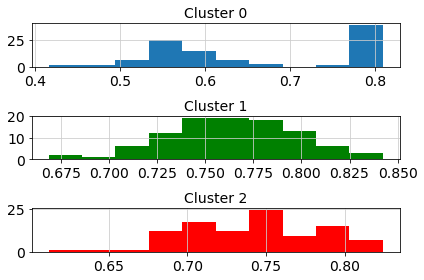

In [61]:
ax = plt.subplot(311)
ax.set_title("Cluster 0")
plt.hist(res['cluster0'], color=None)
ax = plt.subplot(312) # creates 2nd subplot with yellow background
ax.set_title("Cluster 1")
plt.hist(res['cluster1'], color='g')
ax = plt.subplot(313) # creates 2nd subplot with yellow background
ax.set_title("Cluster 2")
plt.hist(res['cluster2'], color='r')
plt.tight_layout()

In [48]:
# pickle.dump( res, open( "bootstrap_results.pickle", "wb" ) )